<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Deep Learning</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

np.random.seed(123)
import math

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: cb359d5f1b6a097e176b437218ac5ab9b4f6dec9

json      : 2.0.9
tensorflow: 2.5.0
numpy     : 1.19.2
keras     : 2.4.3
watermark : 2.1.0
pandas    : 1.1.3
matplotlib: 3.3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Load dataset

GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [4]:
dataset = pd.read_csv('data/GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

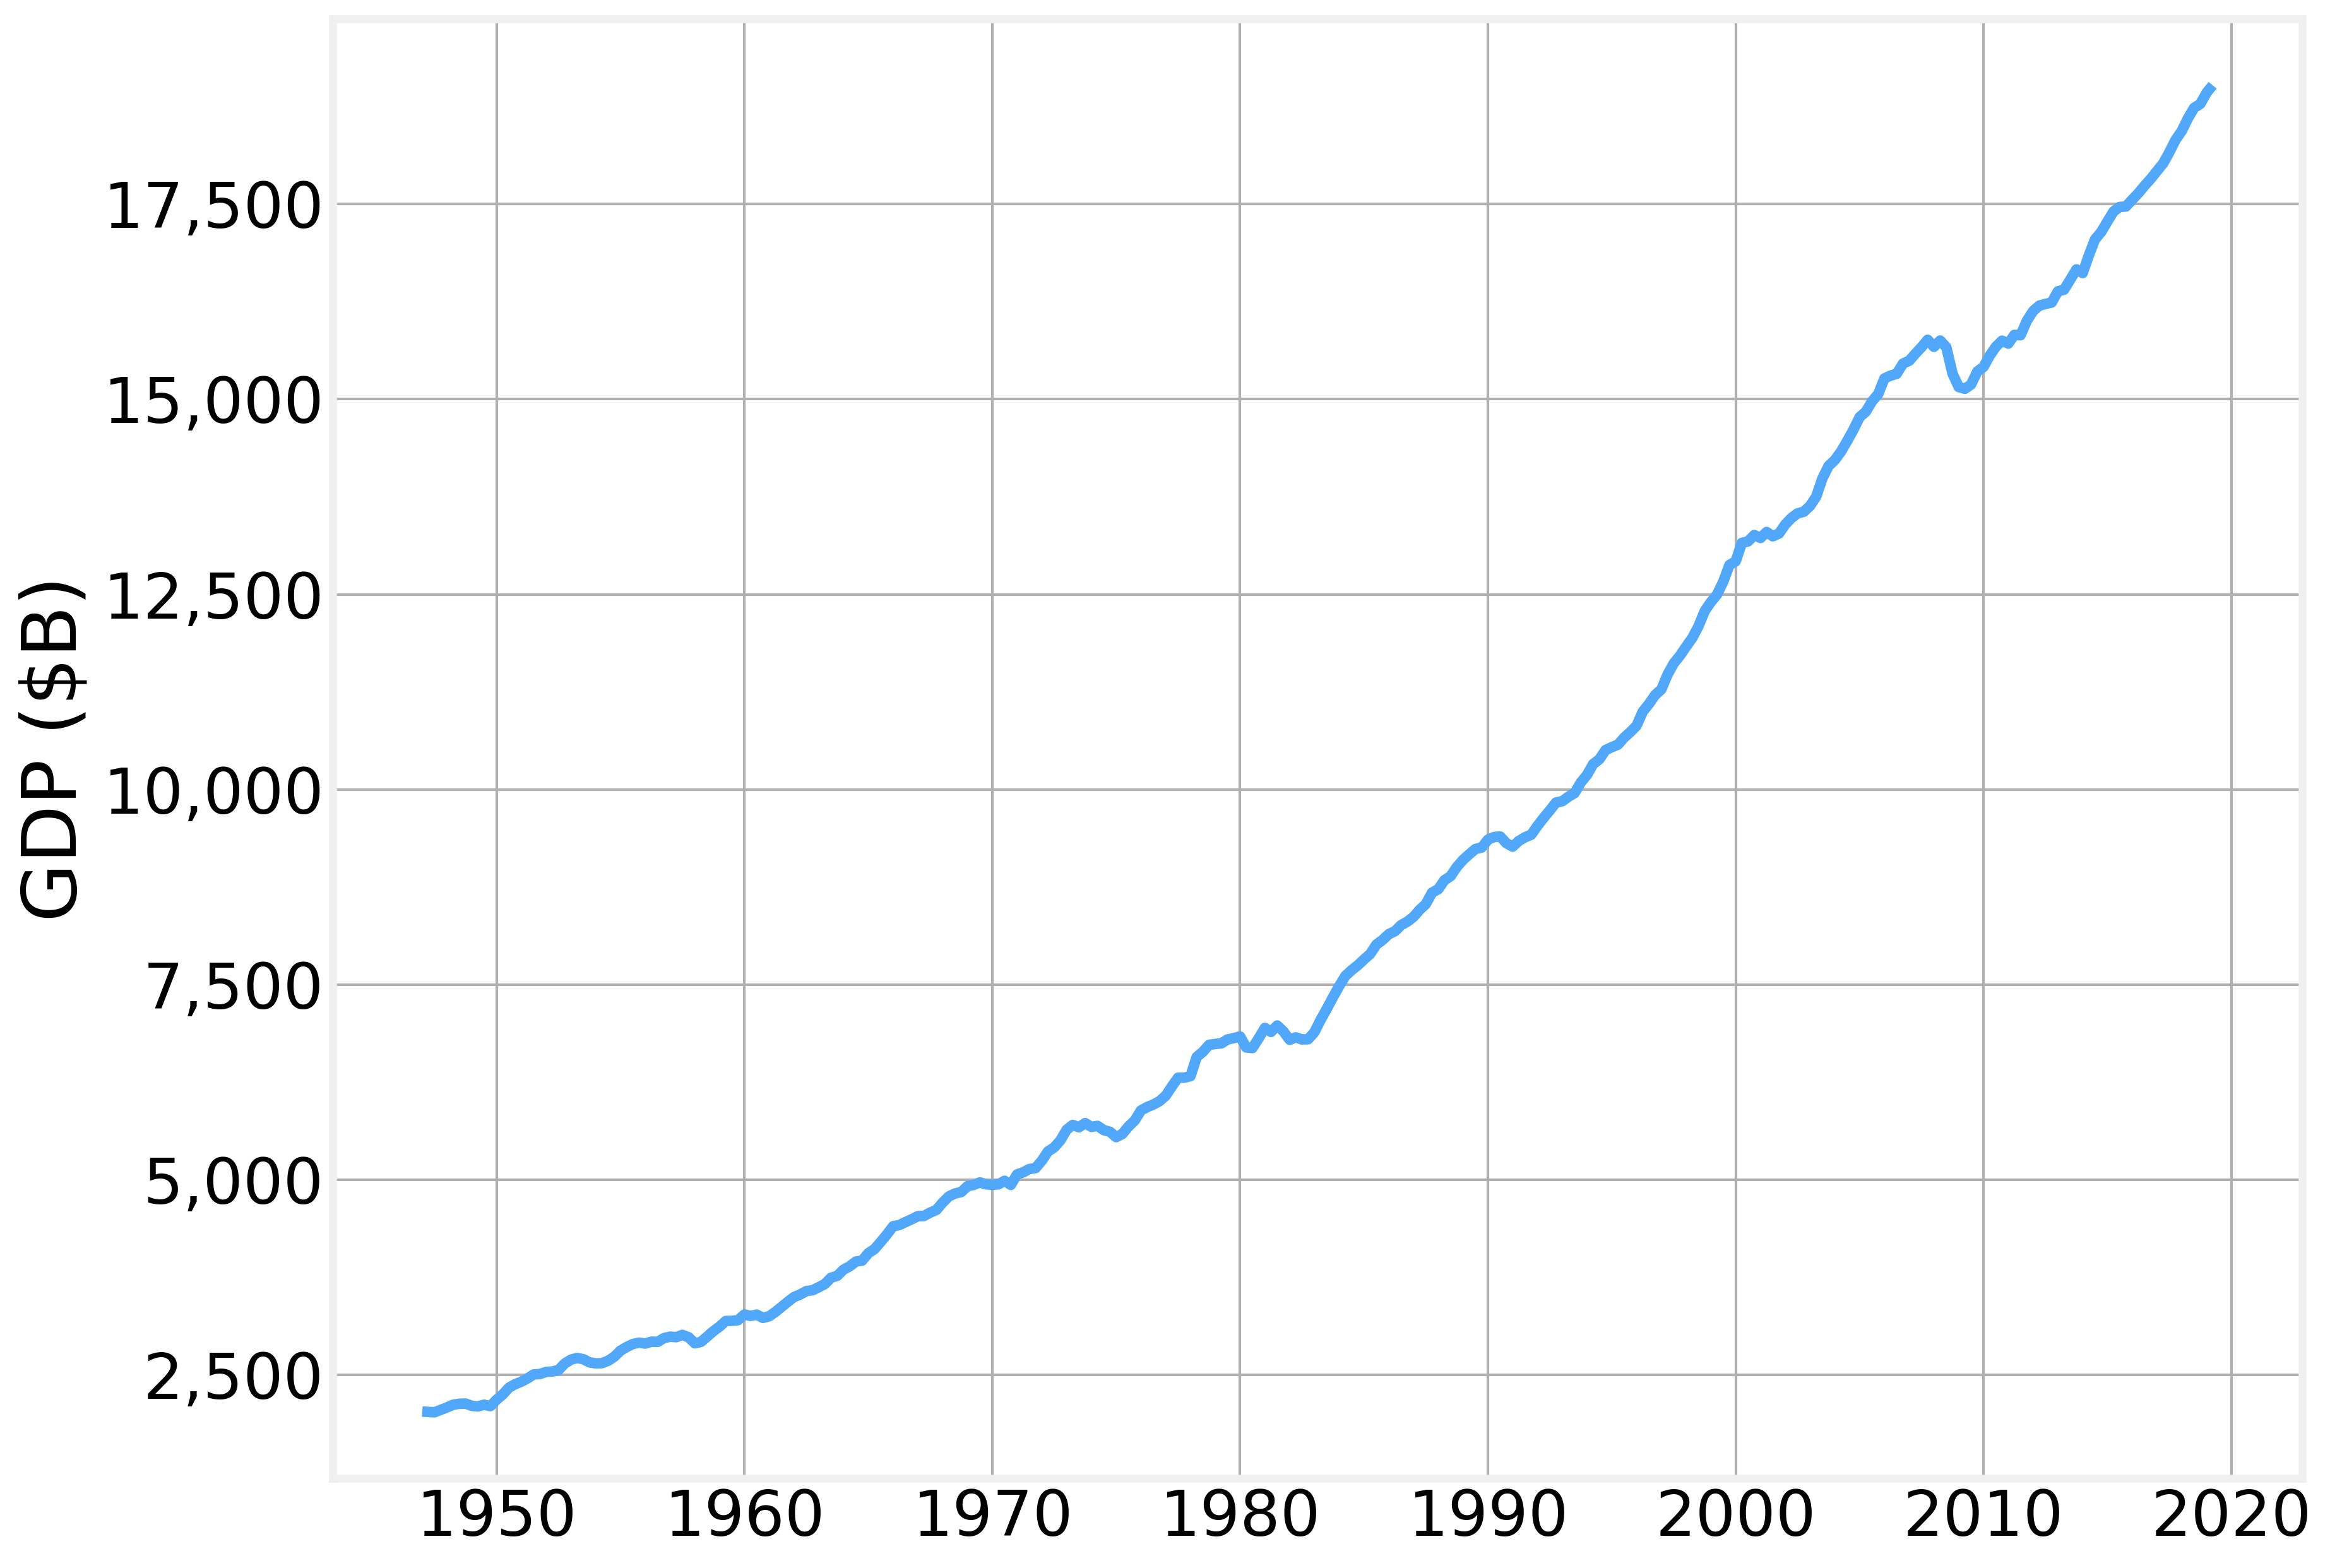

In [5]:
plt.plot(dataset['GDP'])
plt.xlabel(None)
plt.ylabel('GDP ($B)')
plt.gca().get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

You might remember the little "dip" around 2009.

## Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [6]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1,1)
dataset.loc[1:, 'diff']=series

A quick plot...

Text(0, 0.5, 'count')

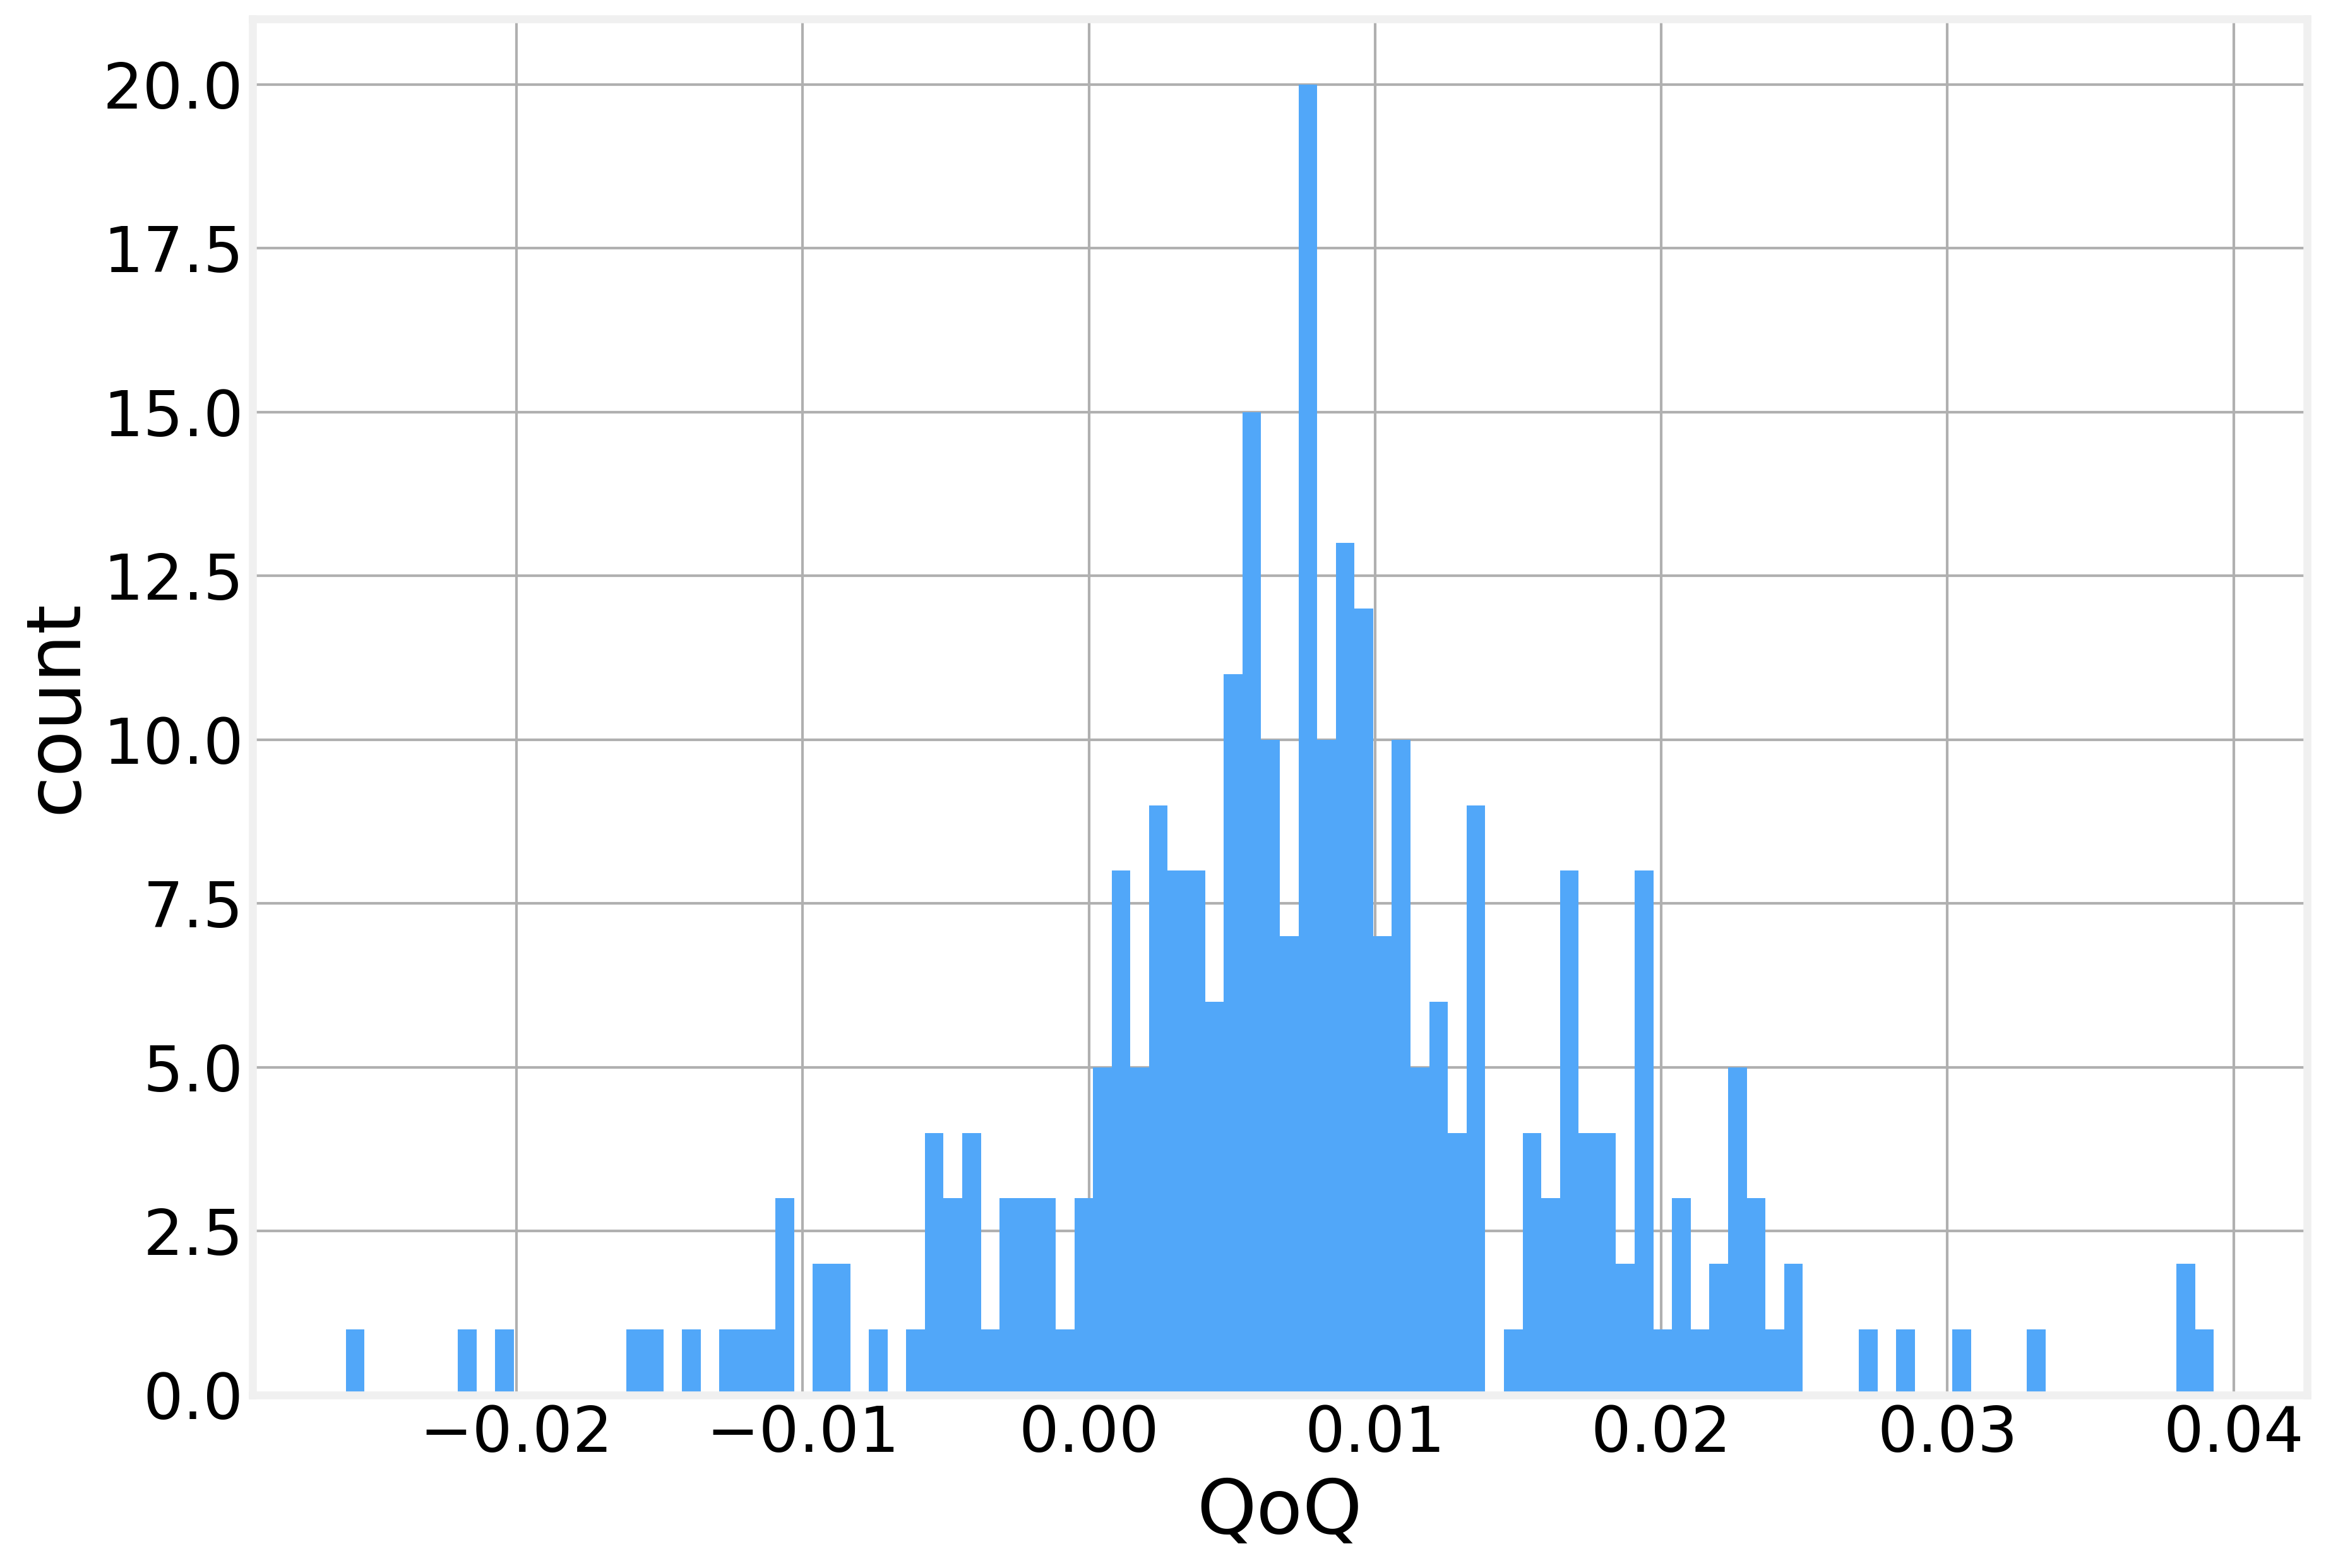

In [7]:
dataset['diff'].hist(bins=100)
plt.xlabel('QoQ')
plt.ylabel('count')

## Training and Testing datasets 
The y values are just the next x value

In [8]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [9]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 193 training points and 95 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [10]:
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(193, 1, 1)
(95, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [11]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [12]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Epoch 1/100
13/13 [==============================] - 11s 951us/step - loss: 0.2092
Epoch 2/100
13/13 [==============================] - 0s 776us/step - loss: 0.1829
Epoch 3/100
13/13 [==============================] - 0s 780us/step - loss: 0.1801
Epoch 4/100
13/13 [==============================] - 0s 756us/step - loss: 0.1672
Epoch 5/100
13/13 [==============================] - 0s 760us/step - loss: 0.1444
Epoch 6/100
13/13 [==============================] - 0s 745us/step - loss: 0.1338
Epoch 7/100
13/13 [==============================] - 0s 722us/step - loss: 0.1167
Epoch 8/100
13/13 [==============================] - 0s 698us/step - loss: 0.1159
Epoch 9/100
13/13 [==============================] - 0s 677us/step - loss: 0.1110
Epoch 10/100
13/13 [==============================] - 0s 706us/step - loss: 0.1101
Epoch 11/100
13/13 [==============================] - 0s 694us/step - loss: 0.0990
Epoch 12/100
13/13 [==============================] - 0s 706us/step - loss: 0.1028
Epoch 13/100

13/13 [==============================] - 0s 778us/step - loss: 0.1174
Epoch 100/100
13/13 [==============================] - 0s 752us/step - loss: 0.0962


## Make predictions

In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

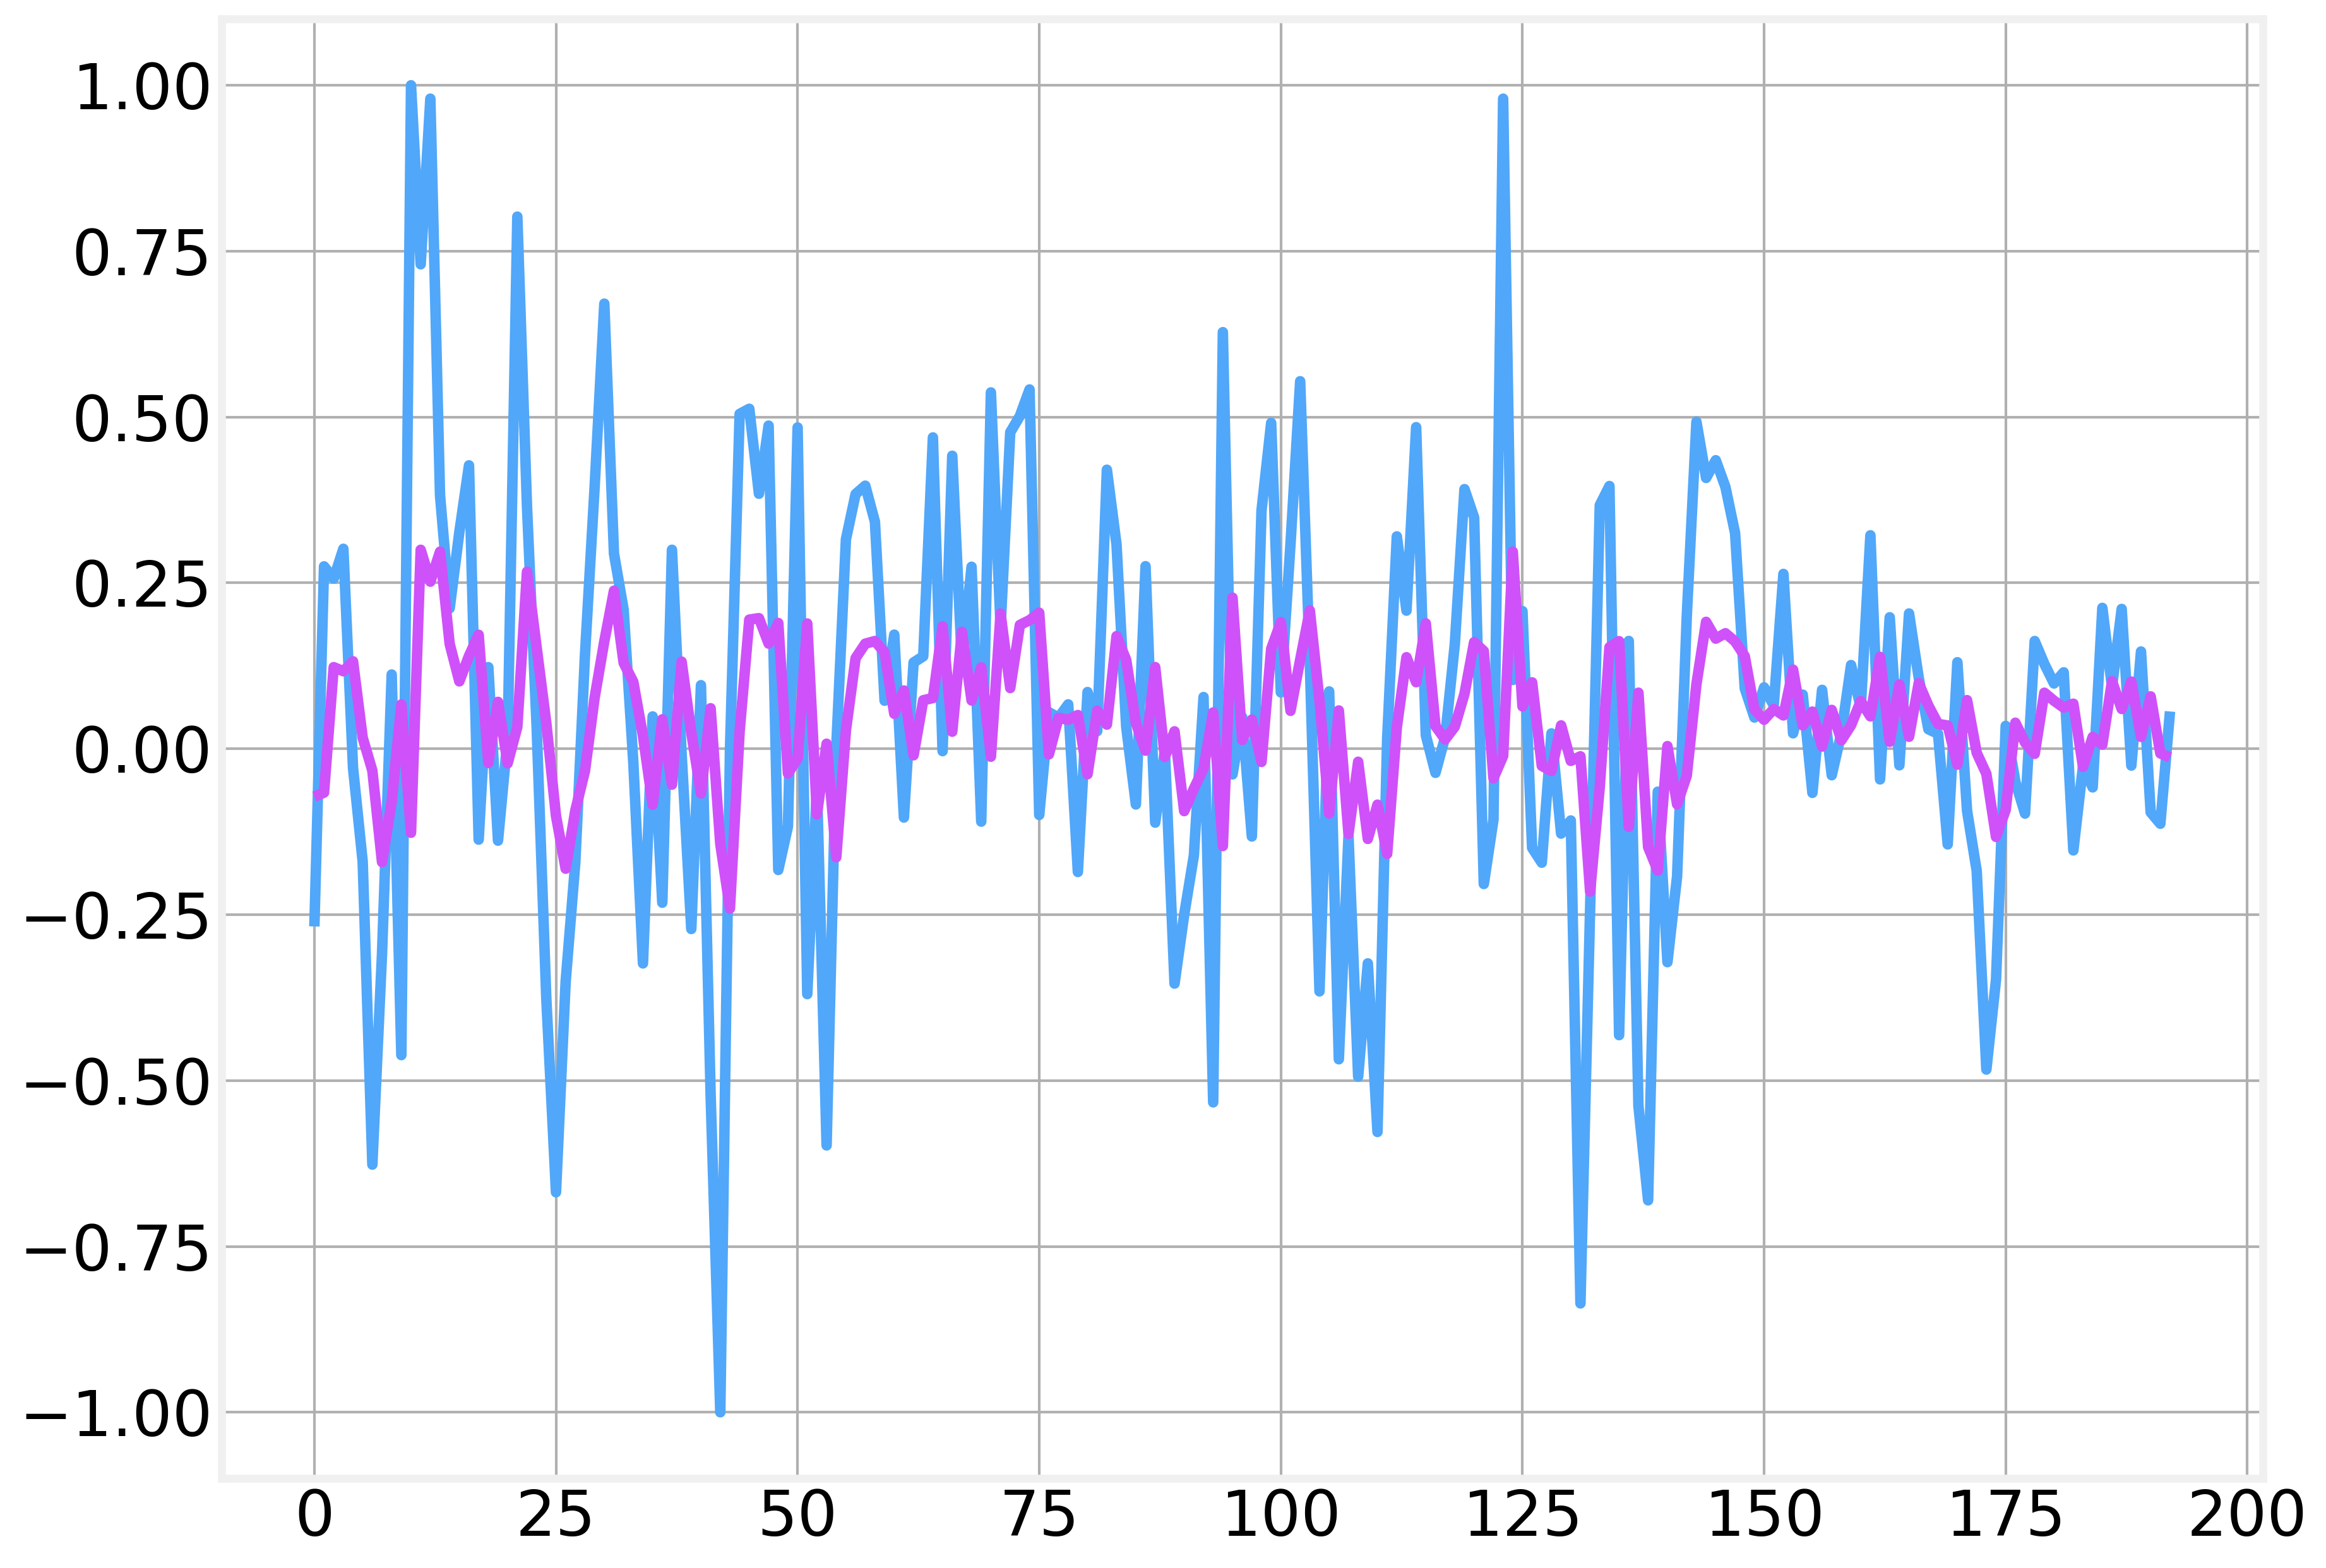

In [14]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

Compute the actual values

In [15]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

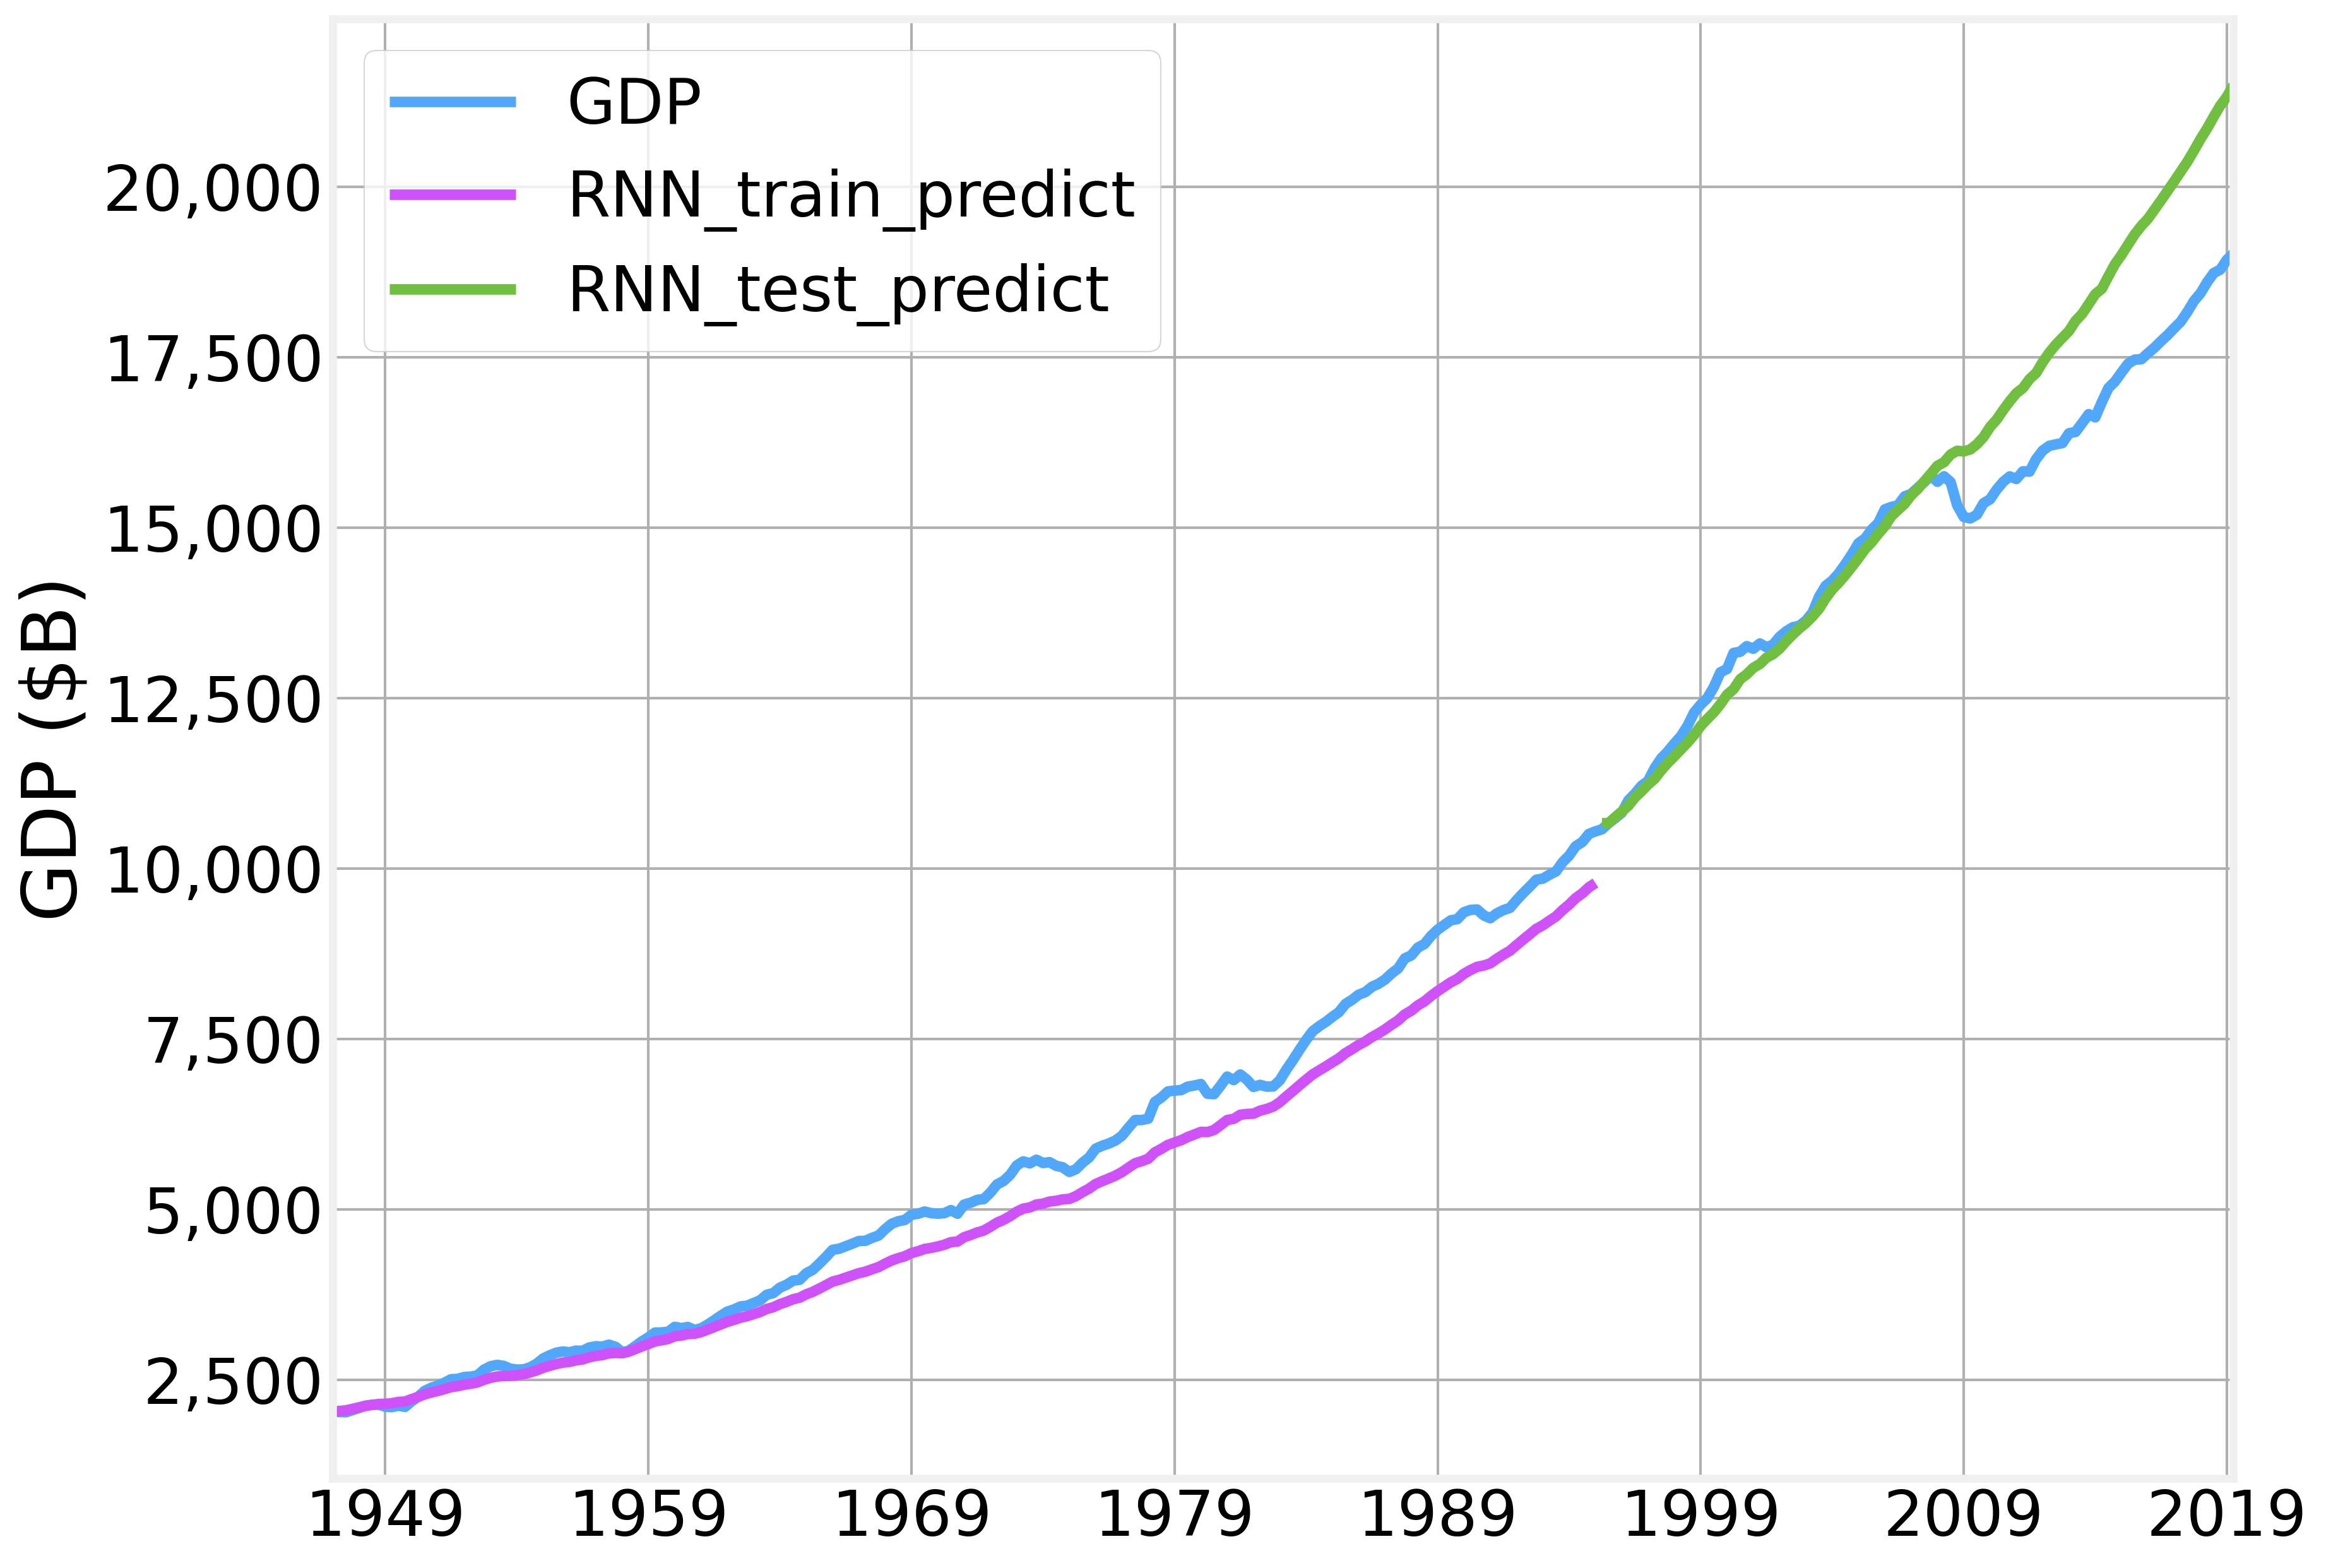

In [16]:
ax = dataset[['GDP']].plot()
dataset[['RNN_train_predict']][:train_points].plot(ax=ax)
dataset[['RNN_test_predict']][train_points:].plot(ax=ax)
ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## LSTM
Let's now try using a slightly more sophisticated architecture

In [17]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [19]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
7/7 [==============================] - 2s 2ms/step - loss: 0.1036
Epoch 2/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1224
Epoch 3/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0938
Epoch 4/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1115
Epoch 5/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0901
Epoch 6/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0819
Epoch 7/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0872
Epoch 8/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0959
Epoch 9/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 10/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 11/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 12/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0892
Epoch 13/500
7/7 [==============================] - 0s 1ms/st

7/7 [==============================] - 0s 1ms/step - loss: 0.0987
Epoch 105/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0907
Epoch 106/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0945
Epoch 107/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 108/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0778
Epoch 109/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0849
Epoch 110/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0928
Epoch 111/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 112/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0836
Epoch 113/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0936
Epoch 114/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1040
Epoch 115/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0969
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0880
Epoch 207/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0837
Epoch 208/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0983
Epoch 209/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0831
Epoch 210/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0998
Epoch 211/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0852
Epoch 212/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0826
Epoch 213/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0983
Epoch 214/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 215/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0973
Epoch 216/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 217/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.1032
Epoch 309/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0946
Epoch 310/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 311/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0770
Epoch 312/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 313/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0831
Epoch 314/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 315/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0835
Epoch 316/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0979
Epoch 317/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0839
Epoch 318/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0872
Epoch 319/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1025
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 411/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0851
Epoch 412/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0834
Epoch 413/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0935
Epoch 414/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0857
Epoch 415/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0902
Epoch 416/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0910
Epoch 417/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1055
Epoch 418/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0971
Epoch 419/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0862
Epoch 420/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 421/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0896
Epoch 422/500
7/7 [==============================] - 0

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 1
dataset['LSTM_test_predict'] = 1
dataset.loc[1:train_points+1, 'LSTM_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'LSTM_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM_train_predict'].cumprod()
dataset['LSTM_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM_test_predict'].cumprod()

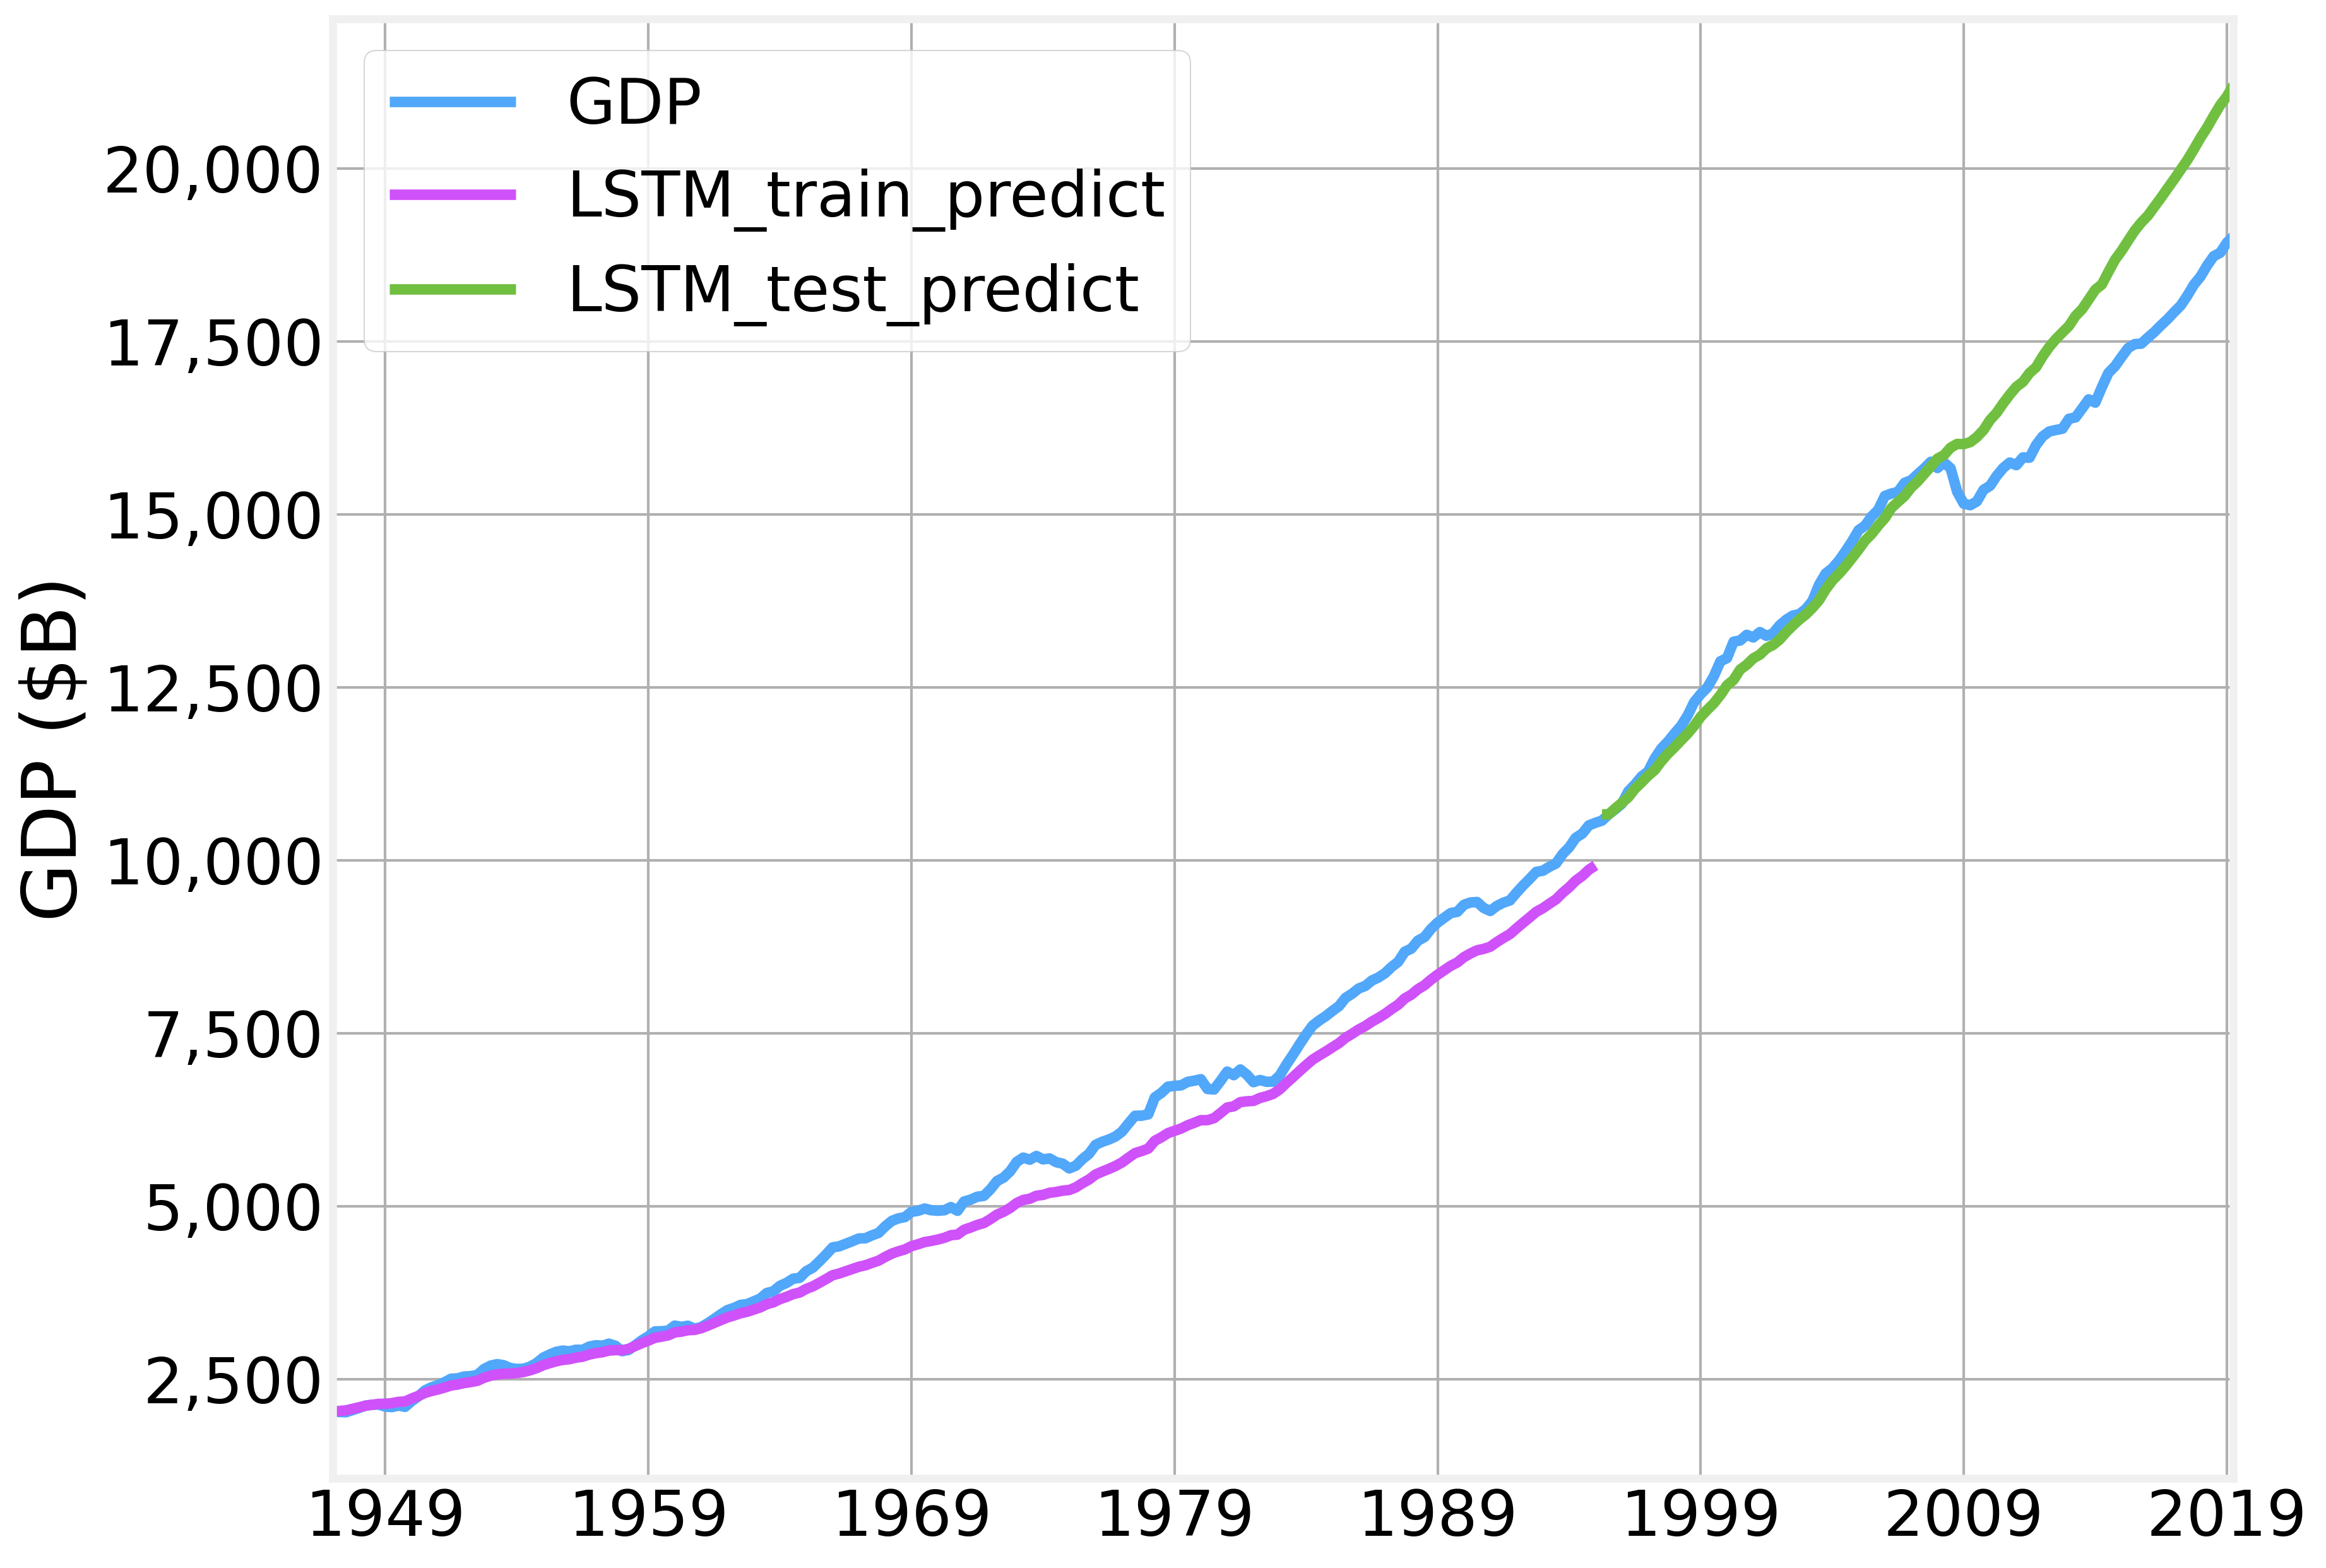

In [21]:
ax = dataset[['GDP']].plot()
# dataset[['RNN_train_predict']][:train_points].plot(ax=ax)
# dataset[['RNN_test_predict']][train_points:].plot(ax=ax)
dataset[['LSTM_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM_test_predict']][train_points:].plot(ax=ax)

ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [22]:
X2 = np.concatenate([X[0:-4], X[1:-3], X[2:-2], X[3:-1]], axis=1)
y2 = X[4:]

X2_train, X2_test = X2[:train_points], X2[train_points:]
y2_train, y2_test = y2[:train_points], y2[train_points:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 193 training points and 91 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [23]:
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(193, 4, 1)
(91, 4, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [24]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [25]:
nb_epoch = 500
model.fit(X2_train, y2_train, epochs=nb_epoch, batch_size=12)

Epoch 1/500
17/17 [==============================] - 1s 2ms/step - loss: 0.1283
Epoch 2/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1202
Epoch 3/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1181
Epoch 4/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0995
Epoch 5/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0907
Epoch 6/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 7/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1037
Epoch 8/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1065
Epoch 9/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1151
Epoch 10/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1020
Epoch 11/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1122
Epoch 12/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1092
Epoch 13/500
17/17 [=================

17/17 [==============================] - 0s 2ms/step - loss: 0.0761
Epoch 102/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0817
Epoch 103/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0776
Epoch 104/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0914
Epoch 105/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 106/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0781
Epoch 107/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 108/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1068
Epoch 109/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0905
Epoch 110/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1006
Epoch 111/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0978
Epoch 112/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0801
Epoch 113/500
17/17 [=========

17/17 [==============================] - 0s 2ms/step - loss: 0.0768
Epoch 202/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0914
Epoch 203/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 204/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0734
Epoch 205/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0949
Epoch 206/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0678
Epoch 207/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0903
Epoch 208/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 209/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0765
Epoch 210/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0836
Epoch 211/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 212/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0758
Epoch 213/500
17/17 [=========

17/17 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 302/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0797
Epoch 303/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0808
Epoch 304/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 305/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0838
Epoch 306/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0859
Epoch 307/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0854
Epoch 308/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1085
Epoch 309/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0872
Epoch 310/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 311/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0907
Epoch 312/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0823
Epoch 313/500
17/17 [=========

17/17 [==============================] - 0s 2ms/step - loss: 0.0909
Epoch 402/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0807
Epoch 403/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0989
Epoch 404/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0800
Epoch 405/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 406/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0944
Epoch 407/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 408/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0779
Epoch 409/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0946
Epoch 410/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0933
Epoch 411/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0744
Epoch 412/500
17/17 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 413/500
17/17 [=========

In [26]:
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

dataset['LSTM3_train_predict'] = 1
dataset['LSTM3_test_predict'] = 1
dataset.loc[4:train_points+4, 'LSTM3_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+6:, 'LSTM3_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM3_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM3_train_predict'].cumprod()
dataset['LSTM3_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM3_test_predict'].cumprod()

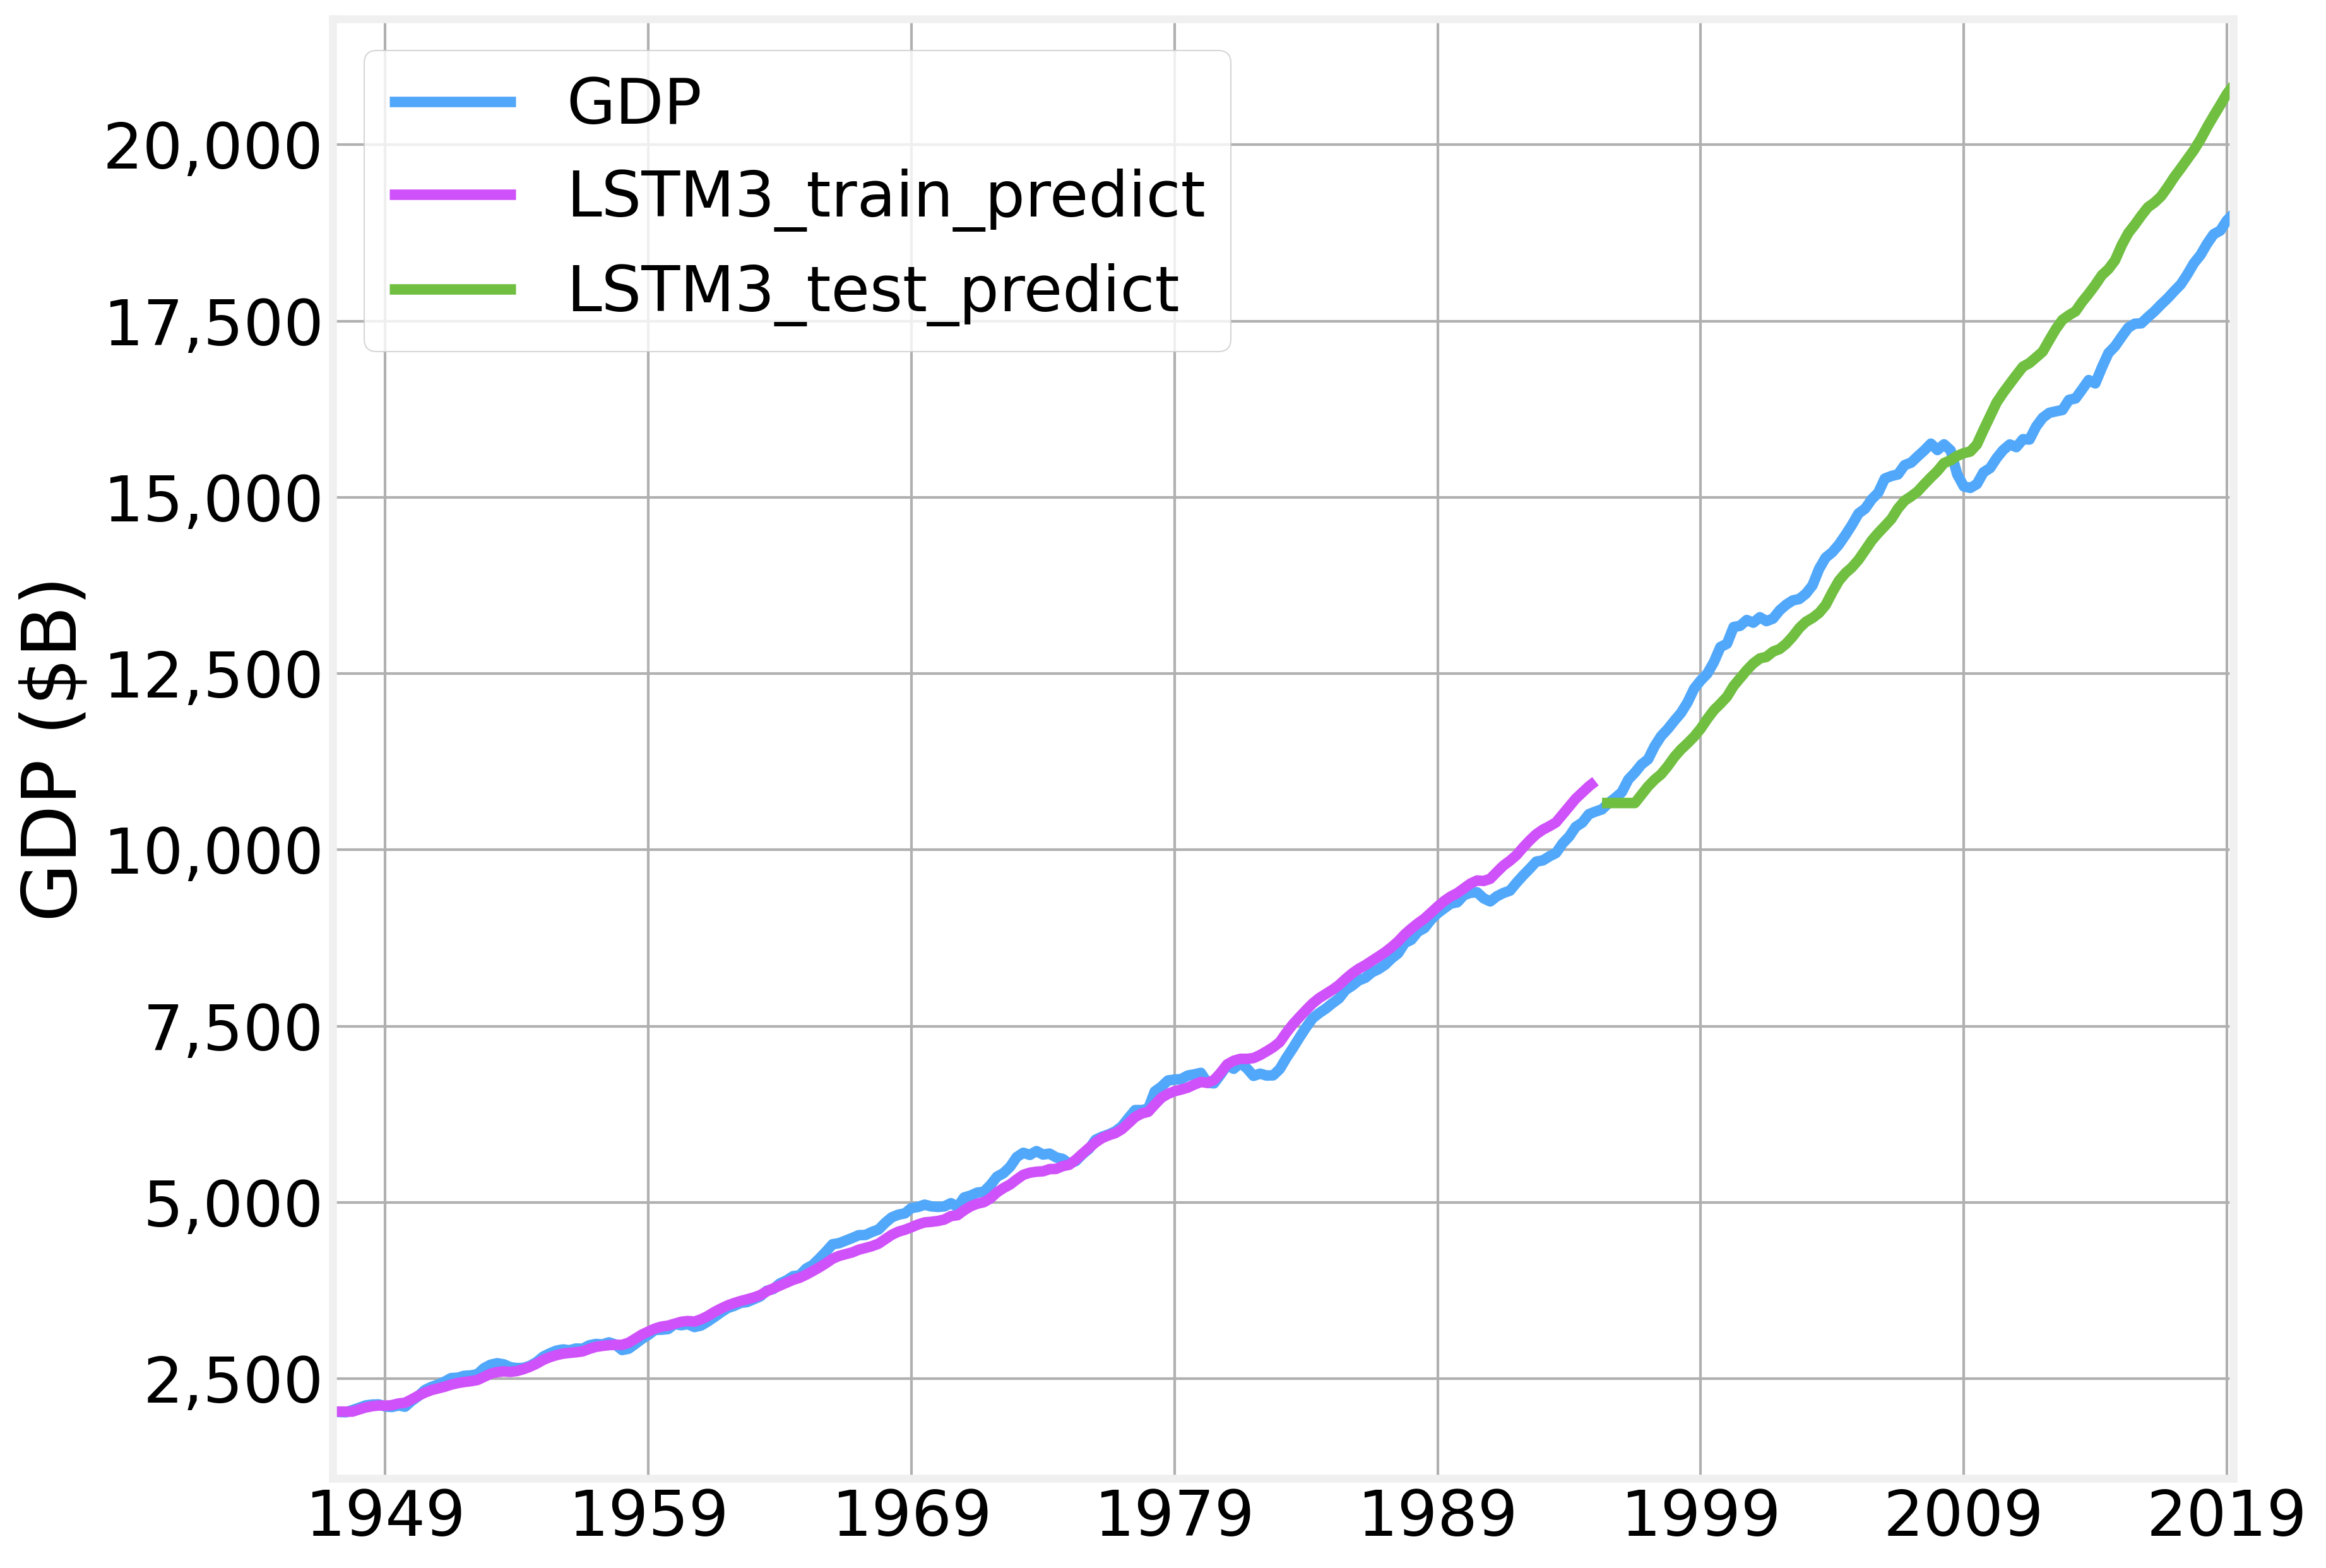

In [27]:
ax = dataset[['GDP']].plot()
# dataset[['RNN_train_predict']][:train_points].plot(ax=ax)
# dataset[['RNN_test_predict']][train_points:].plot(ax=ax)
# dataset[['LSTM_train_predict']][:train_points].plot(ax=ax)
# dataset[['LSTM_test_predict']][train_points:].plot(ax=ax)
dataset[['LSTM3_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM3_test_predict']][train_points:].plot(ax=ax)


ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## GRU

Now we look at the GRU architecture, following similar approaches to the ones used above

In [28]:
model = Sequential()
model.add(GRU(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 4)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [30]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
7/7 [==============================] - 2s 2ms/step - loss: 0.1027
Epoch 2/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1150
Epoch 3/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0960
Epoch 4/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 5/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1033
Epoch 6/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 7/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0896
Epoch 8/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1061
Epoch 9/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0872
Epoch 10/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0862
Epoch 11/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0983
Epoch 12/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 13/500
7/7 [==============================] - 0s 1ms/st

7/7 [==============================] - 0s 1ms/step - loss: 0.1006
Epoch 105/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 106/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0851
Epoch 107/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0873
Epoch 108/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0945
Epoch 109/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1076
Epoch 110/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0898
Epoch 111/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1040
Epoch 112/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1094
Epoch 113/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0919
Epoch 114/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0784
Epoch 115/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0916
Epoch 207/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0912
Epoch 208/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0930
Epoch 209/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0934
Epoch 210/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 211/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0879
Epoch 212/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0860
Epoch 213/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0864
Epoch 214/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0852
Epoch 215/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0886
Epoch 216/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0879
Epoch 217/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 309/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0826
Epoch 310/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0852
Epoch 311/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 312/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1046
Epoch 313/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0907
Epoch 314/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0907
Epoch 315/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0928
Epoch 316/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0940
Epoch 317/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0862
Epoch 318/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0828
Epoch 319/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0999
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 411/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 412/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0945
Epoch 413/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0932
Epoch 414/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0881
Epoch 415/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0930
Epoch 416/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1001
Epoch 417/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0890
Epoch 418/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0941
Epoch 419/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0934
Epoch 420/500
7/7 [==============================] - 0s 1ms/step - loss: 0.1012
Epoch 421/500
7/7 [==============================] - 0s 1ms/step - loss: 0.0976
Epoch 422/500
7/7 [==============================] - 0

In [31]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['GRU_train_predict'] = 1
dataset['GRU_test_predict'] = 1
dataset.loc[1:train_points+1, 'GRU_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'GRU_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['GRU_train_predict'] = dataset.iloc[0]['GDP']*dataset['GRU_train_predict'].cumprod()
dataset['GRU_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['GRU_test_predict'].cumprod()

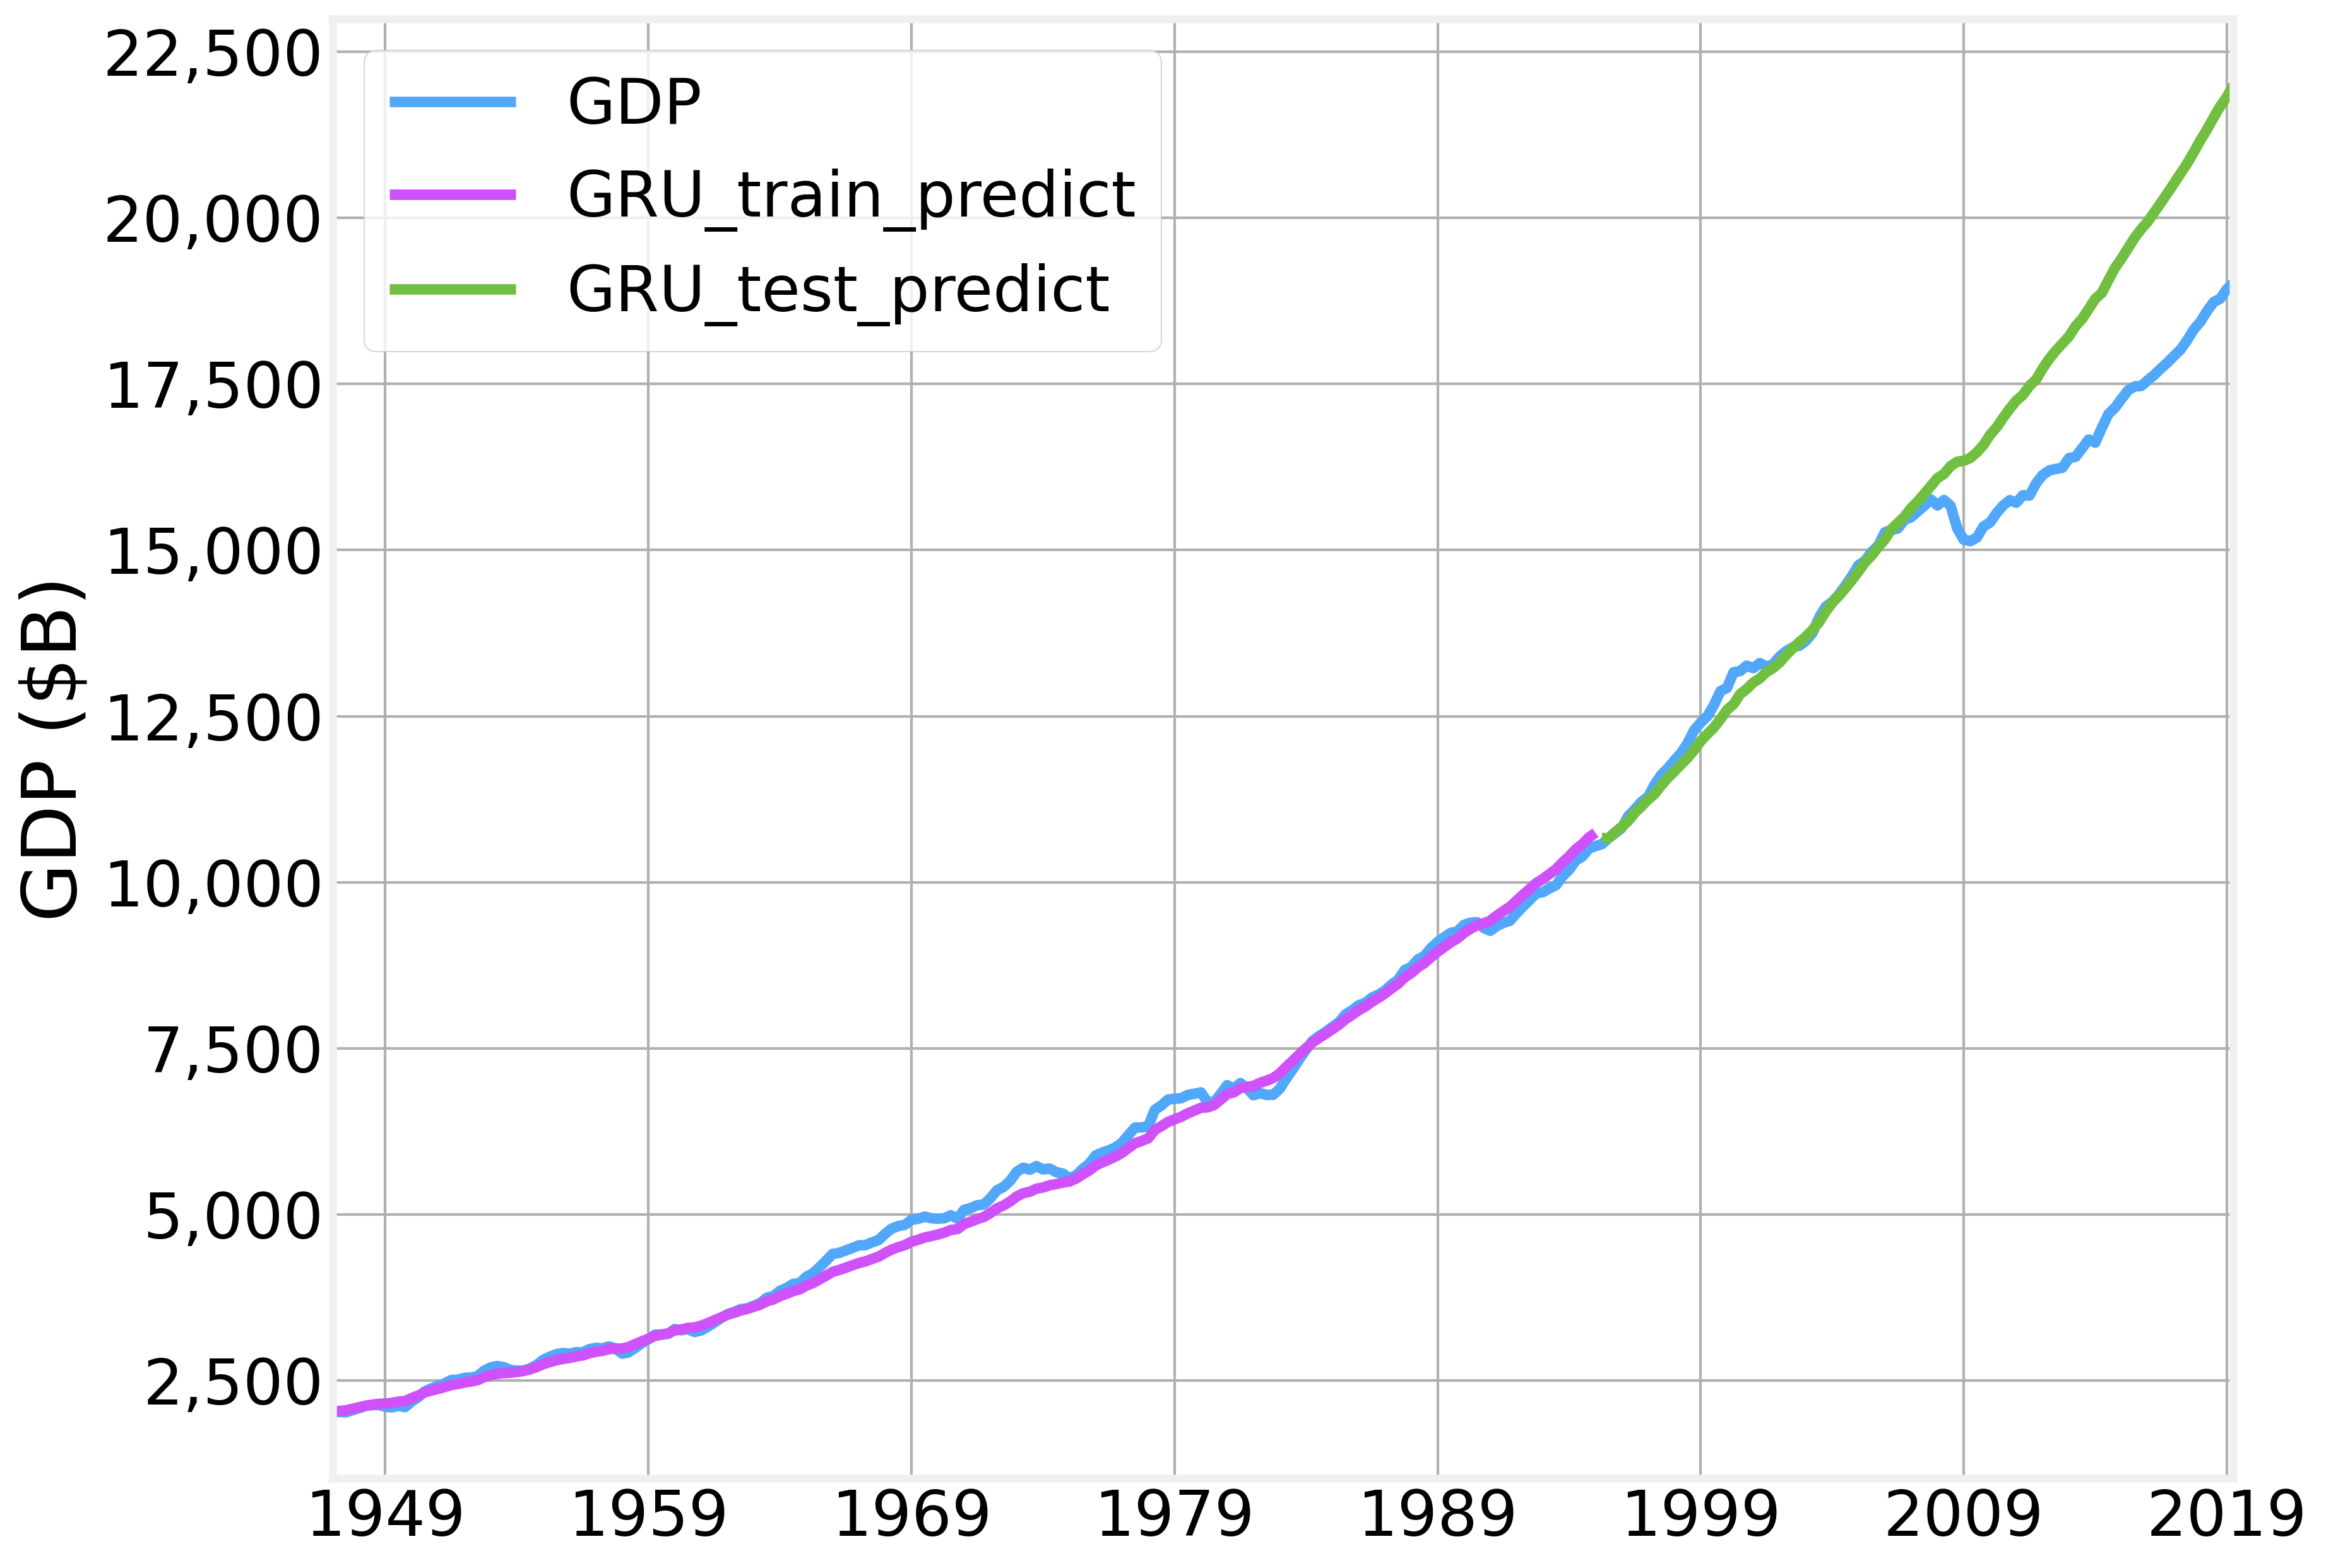

In [32]:
ax = dataset[['GDP']].plot()
dataset[['GRU_train_predict']][:train_points].plot(ax=ax)
dataset[['GRU_test_predict']][train_points:].plot(ax=ax)


ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

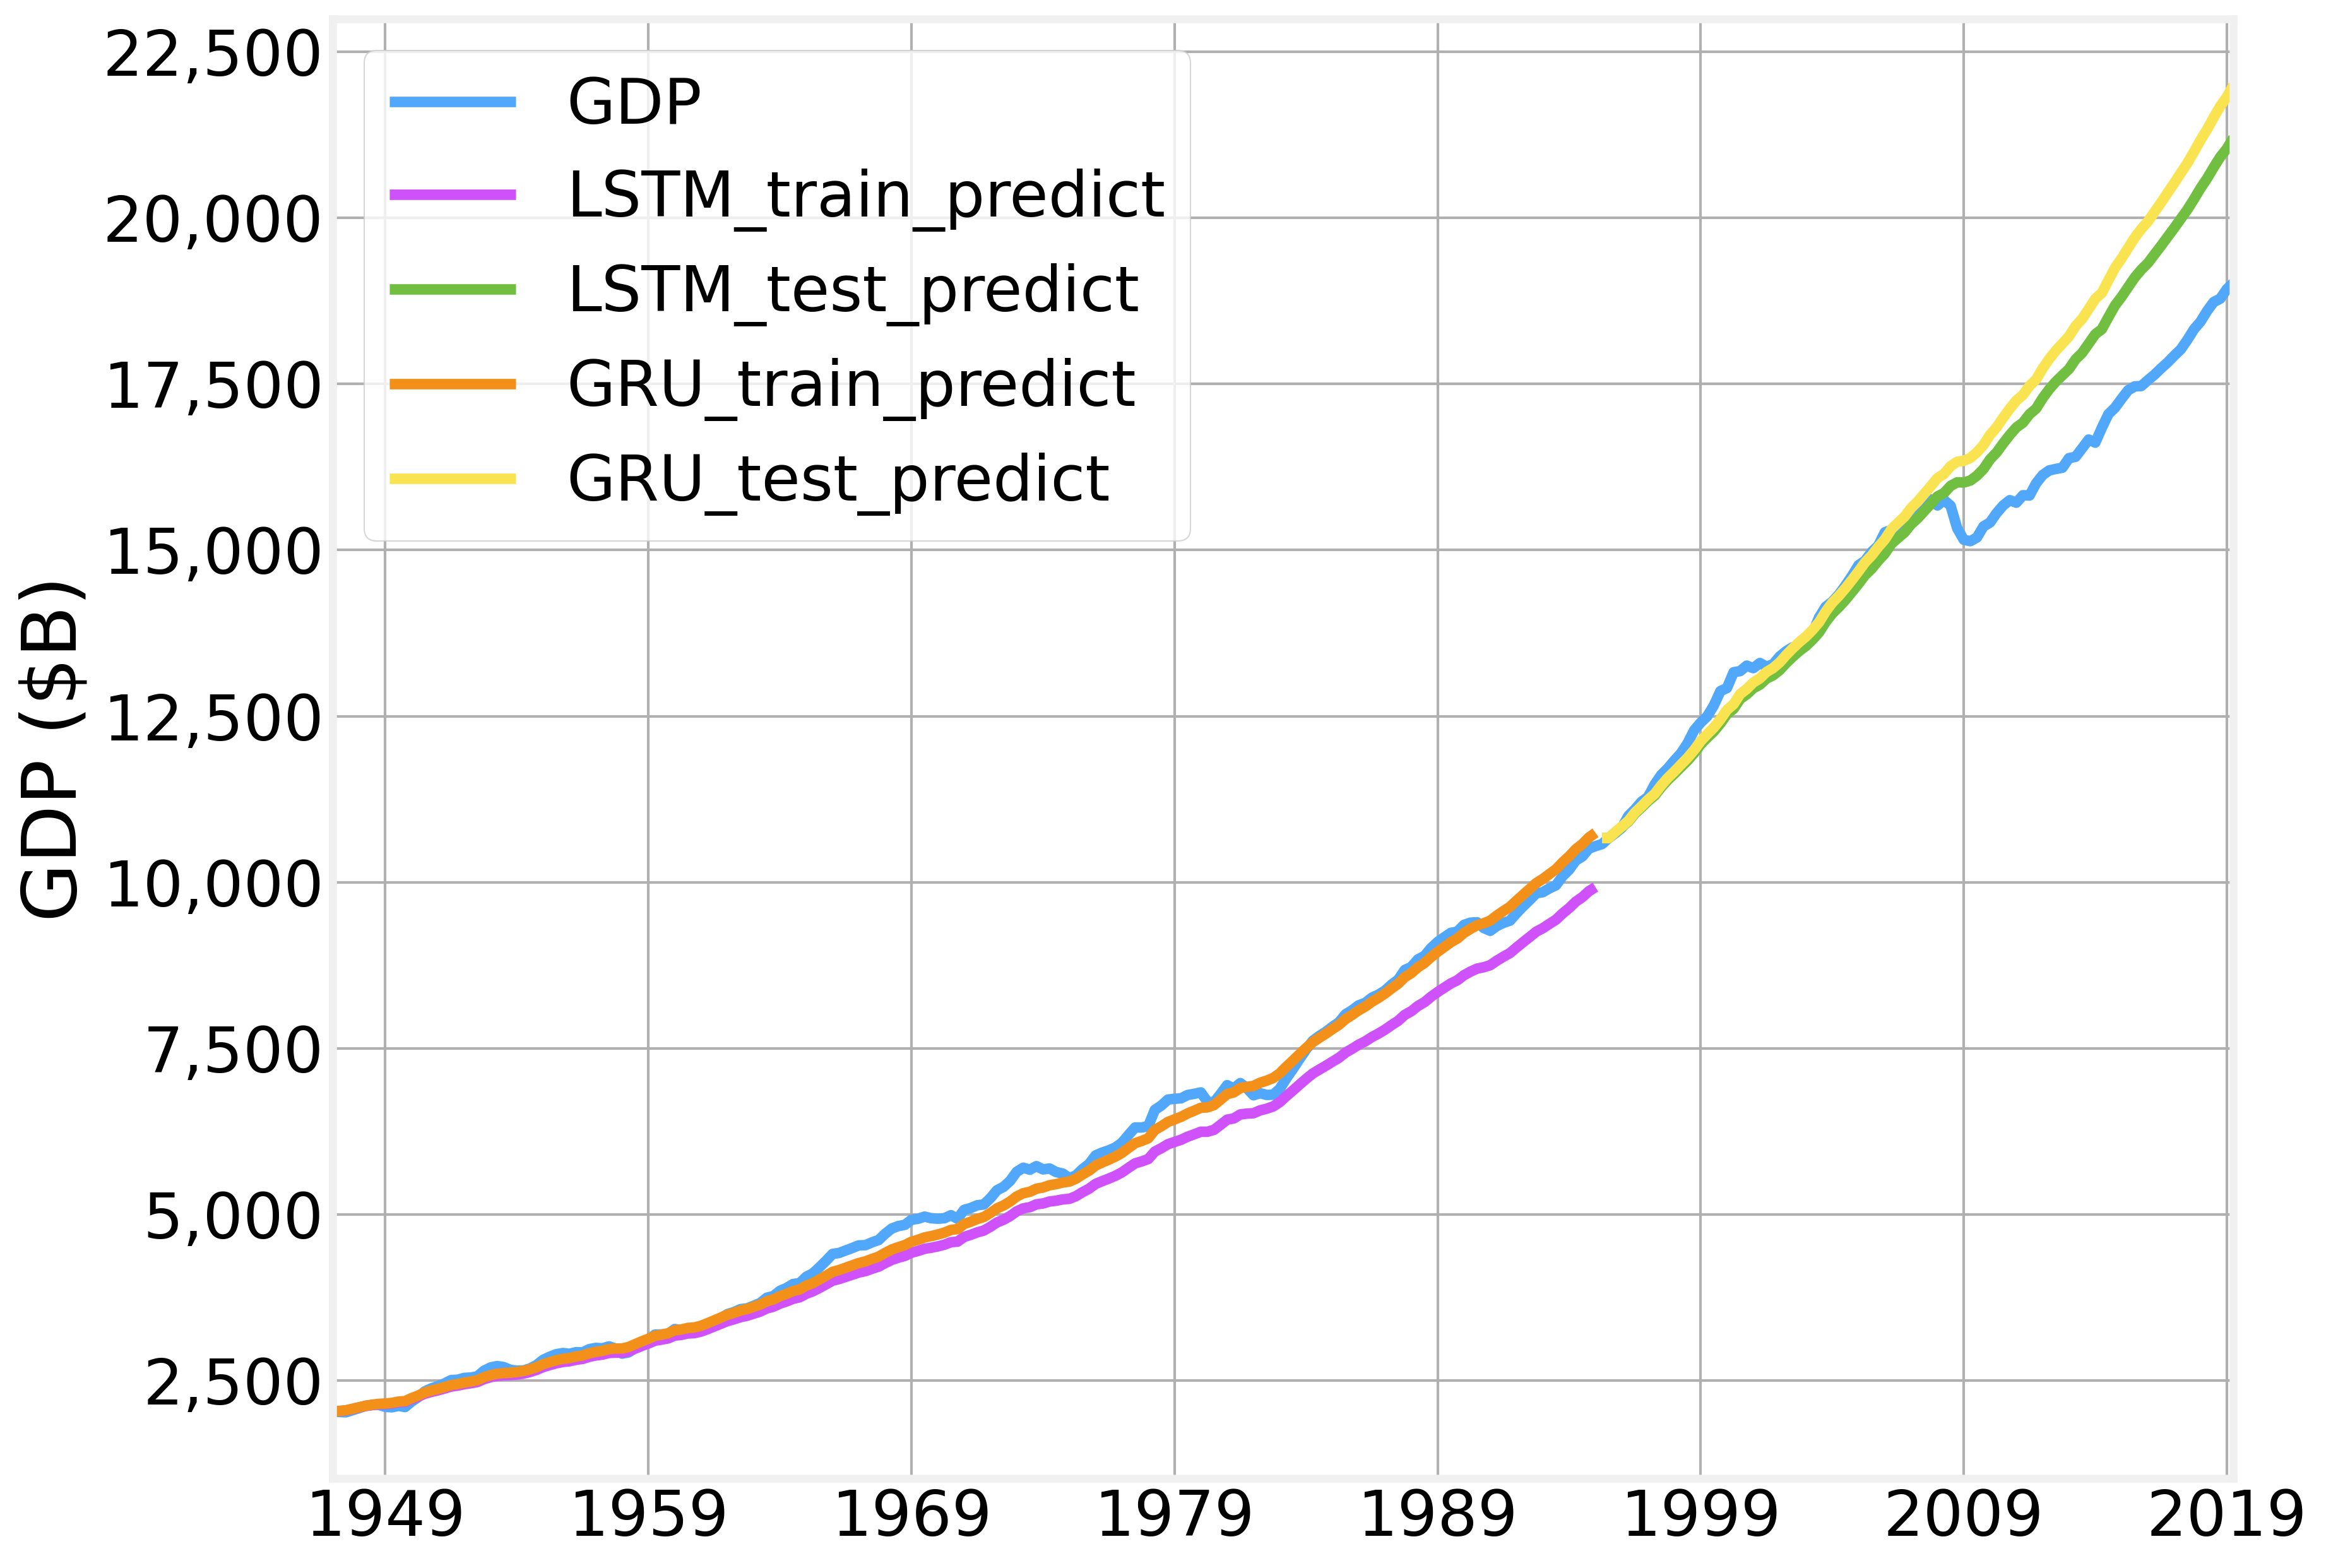

In [33]:
ax = dataset[['GDP']].plot()
dataset[['LSTM_train_predict']][:train_points].plot(ax=ax)
dataset[['LSTM_test_predict']][train_points:].plot(ax=ax)
dataset[['GRU_train_predict']][:train_points].plot(ax=ax)
dataset[['GRU_test_predict']][train_points:].plot(ax=ax)


ax.set_xlabel(None)
ax.set_ylabel('GDP ($B)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>